In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flickr8k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F623289%2F1111676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240519%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240519T104247Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9c926444398b60e4af115e0bcca47d5f124d2e080ea73b298f32ec42ca5b52f96ffa5356df24b523eb8512f0ef0cf3b3ef69e2e52e3575ec226935b73c41389fd8f7f8f70d78b4cb9b14728ed136540ccc778daf61ab22c0b8aaedc4ad6cc0ea5e50a3249dac5f757c20cbb9ebe0764d4463e833b1168a9a704db76e5fb642127f965d6c24815d00b97b3718509d393409fafeaa5247337893422e4de744db8801a1aa16d1cd9ec4e98e2ee3649f4da1cac0e731ca1f7c0aef5f27c33508879698f54f3527d46baba78f953bbdcee43b7143a0b3520af3193e5ff93de7bd18461d57c610b60cfdb81f3ea92456336b5e876b0cd1934a47bbe97d68c01dde07b8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1112971163 bytes downloaded
Downloaded and uncompressed: flickr8k
Data source import complete.


In [2]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import os
import pickle
from tqdm.notebook import tqdm
import tensorflow as tf
from keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , GlobalAveragePooling2D,Flatten, LSTM, Embedding, Dropout, add, Input,Concatenate
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model

In [3]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# Adjusting ResNet

In [4]:
incemt_model = ResNet50(include_top = True,weights = 'imagenet', input_shape = (224,224,3))
# Freeze the layers of the ResNet-50 model
for layer in incemt_model.layers:
    layer.trainable = False

last_layer = incemt_model.layers[-2].output
feature_extractor = Model(inputs = incemt_model.input, outputs = last_layer)

102967424/102967424 [==============================] - 3s 0us/step


In [ ]:
feature_extractor.summary()

# 1. Loading the images

In [5]:
directory = os.path.join(BASE_DIR,'Images')
pixel_images = {}
for img_name in tqdm(os.listdir(directory)) :
    img_path = directory + '/' + img_name
    img = load_img(img_path, target_size = (224,224))
    img = img_to_array(img)
    img =  preprocess_input(img)
    pixel_images[img_name.split('.')[0]] = img

  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
pickle.dump(pixel_images, open(os.path.join(WORKING_DIR, 'pixel_images.pkl'), 'wb'))

KeyboardInterrupt: 

In [7]:
with open(os.path.join(WORKING_DIR, 'pixel_images.pkl'), 'rb') as f :
    features = pickle.load(f)

Exception ignored in: <function _xla_gc_callback at 0x7e4e51e42050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7e4e51e42050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


EOFError: Ran out of input

(224, 224, 3)


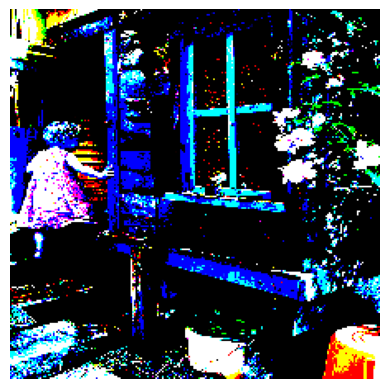

In [8]:
print(pixel_images['1000268201_693b08cb0e'].shape)
plt.imshow(pixel_images['1000268201_693b08cb0e'])
plt.axis('off')  # Hide axes
plt.show()

# 2. Load the captions

In [9]:
with open(os.path.join(BASE_DIR, 'captions.txt')) as f:
    next(f)
    captions_doc = f.read()

In [10]:
image_captions = {}
for line in tqdm(captions_doc.split('\n')) :
    tokens = line.split(',')
    if len(line) < 2 :
        continue
    img_name, caption = tokens[0], tokens[1:]
    img_name = img_name.split('.')[0]
    caption = ' '.join(caption)
    if img_name not in image_captions :
        image_captions[img_name] = [caption]
    else :
        image_captions[img_name].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


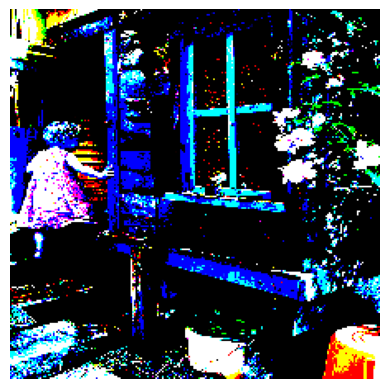

In [11]:
print(image_captions['1000268201_693b08cb0e'])
plt.imshow(pixel_images['1000268201_693b08cb0e'])
plt.axis('off')
plt.show()

In [12]:
def preprocess_caption(image_captions) :
    for img_name, captions in image_captions.items() :
        for i in range(len(captions)):
            caption = captions[i].replace('[^A-Za-z]', '').replace('\s+', ' ').lower()
            caption = '<start> ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' <end>'
            captions[i] = caption

In [13]:
preprocess_caption(image_captions)


In [14]:
image_captions['1000268201_693b08cb0e']

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [15]:
all_captions = []
for img_name in image_captions :
    for caption in image_captions[img_name] :
        all_captions.append(caption)

In [16]:
len(all_captions)
all_captions[:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
max_caption_length = max(len(caption.split()) for caption in all_captions)

# Split the dataset to train, test and validate

In [19]:
img_ids = list(image_captions.keys())
split_train = int(len(img_ids) * 0.75)
train = img_ids[:split_train]
validate_test = img_ids[split_train:]
split_validate = int(len(validate_test) * 0.5)
validate = validate_test[:split_validate]
test = validate_test[split_validate:]

In [20]:
def data_generator(data_keys, image_captions, features, tokenizer, max_caption_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = image_captions[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

# Creating the Model

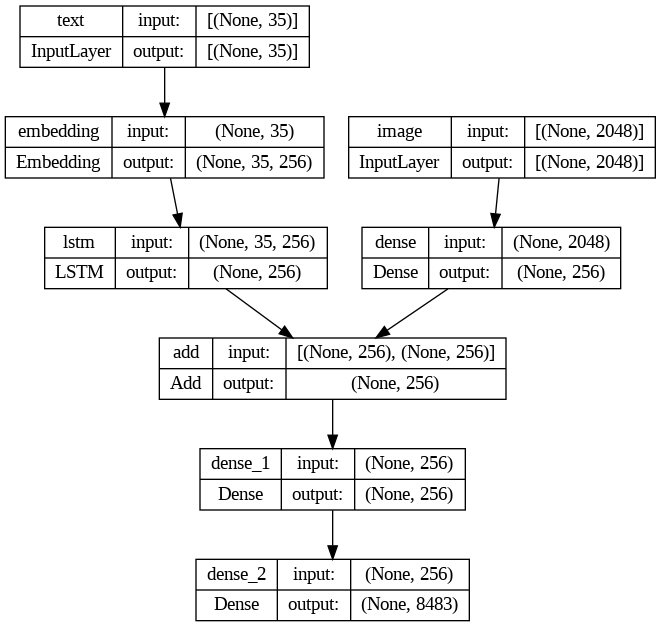

In [22]:
# image feature layers
inputs1 = Input(shape=(2048,), name="image")
# fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(inputs1)
# sequence feature layers
inputs2 = Input(shape=(max_caption_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se1)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

# Extract the features of images

In [23]:
features = {}
for img_name, image in tqdm(pixel_images.items()) :
    img = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    feature = feature_extractor.predict(img, verbose = 0)
    features[img_name] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
features.shape

(8091, 2048, 1)

# Store the features in hard disk

In [24]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [25]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f :
    features = pickle.load(f)

# Train the model

In [26]:
epochs = 30
batch_size = 32
steps = len(train) // batch_size
generator = data_generator(train, image_captions, features, tokenizer, max_caption_length, vocab_size, batch_size)
for i in range(epochs) :
    model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose= 1)

189/189 [==============================] - 48s 255ms/step - loss: 1.6348 - accuracy: 0.5589


In [36]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Generationg the captions from images

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items() :
        if index == integer :
            return word
    return None

In [29]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = ''
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        if word == 'end':
            break
        in_text += " " + word

    return in_text

In [30]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(validate[:5]):
    # get actual caption
    captions = image_captions[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_caption_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/5 [00:00<?, ?it/s]

BLEU-1: 0.269845
BLEU-2: 0.159643


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
print(actual[0])

[['<start>', 'man', 'holding', 'digital', 'camera', 'standing', 'outside', 'of', 'huge', 'building', '<end>'], ['<start>', 'man', 'in', 'blue', 'shirt', 'holding', 'camera', '<end>'], ['<start>', '"a', 'man', 'in', 'blue', 't-shirt', 'holds', 'camera', '<end>'], ['<start>', 'man', 'wearing', 'blue', 'holds', 'camera', '<end>'], ['<start>', 'the', 'man', 'in', 'blue', 'shirt', 'is', 'holding', 'camera', 'near', 'to', 'boy', 'wearing', 'backpack', '<end>']]


In [ ]:

print(predicted[0])

['startseq', 'lecture', 'chairs', 'reading', 'book', 'end', 'end', 'end', 'dad', 'dad', 'dad', 'dad', 'dad', 'corner', 'surrounded', 'by', 'dad', 'dad', 'dad', 'dad', 'photo', 'photo', 'photo', 'photo', 'of', 'eastern', 'group', 'of', 'people', 'stand', 'in', 'front', 'of', 'building', 'end', 'of']


In [31]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_captions[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
generate_caption("1056249424_ef2a2e041c.jpg")

NameError: name 'generate_caption' is not defined

---------------------Actual---------------------
<start> black dog and spotted dog are fighting <end>
<start> black dog and tri-colored dog playing with each other on the road <end>
<start> black dog and white dog with brown spots are staring at each other in the street <end>
<start> two dogs of different breeds looking at each other on the road <end>
<start> two dogs on pavement moving toward each other <end>
--------------------Predicted--------------------
 two dogs play with each other


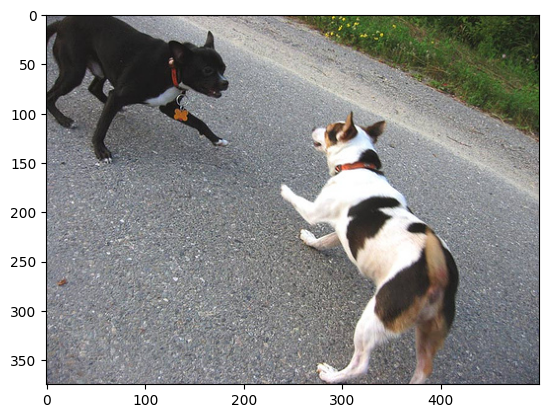

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
<start> man lays on bench while his dog sits by him <end>
<start> man lays on the bench to which white dog is also tied <end>
<start> man sleeping on bench outside with white and black dog sitting next to him <end>
<start> shirtless man lies on park bench with his dog <end>
<start> man laying on bench holding leash of dog sitting on ground <end>
--------------------Predicted--------------------
 man on bench in park


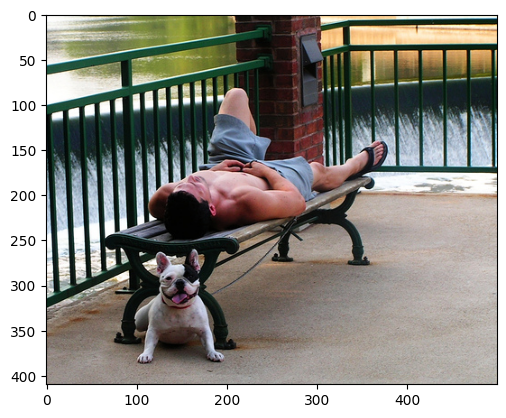

In [ ]:
generate_caption("1003163366_44323f5815.jpg")

# External Image

In [80]:
def generate_external_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/content/drive/MyDrive/external_images', image_name)
    image = Image.open(img_path)
    y_pred = predict_caption(model, external_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [81]:
# directory = os.path.join(BASE_DIR,'external-images')
from google.colab import drive
import os
import glob

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory where your photos are stored
photo_dir = '/content/drive/MyDrive/external_images'
jpg_images = [img_name for img_name in os.listdir(photo_dir) if img_name.lower().endswith('.jpg')]

pixel_images = {}
for img_name in tqdm(os.listdir(photo_dir)) :
    img_path = photo_dir + '/' + img_name
    img = load_img(img_path, target_size = (224,224))
    img = img_to_array(img)
    img =  preprocess_input(img)
    pixel_images[img_name.split('.')[0]] = img

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/8 [00:00<?, ?it/s]

# External Feature Extraction

In [82]:
external_features = {}
for img_name, image in tqdm(pixel_images.items()) :
    img = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    external_feature = feature_extractor.predict(img, verbose = 0)
    external_features[img_name] = external_feature

  0%|          | 0/8 [00:00<?, ?it/s]

--------------------Predicted--------------------
 beautiful beautiful large beautiful large rock grass person man rock climbing with treads


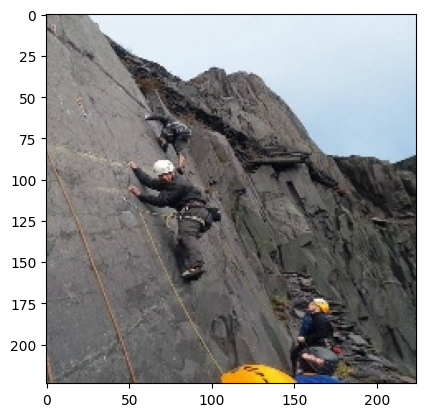

In [79]:
generate_external_caption(jpg_images[4])

--------------------Predicted--------------------
 dog leaving the grass


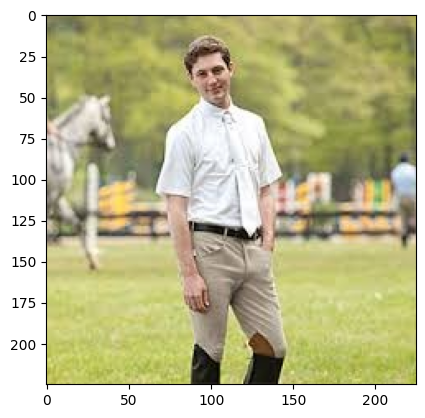

In [64]:
generate_external_caption(jpg_images[2])

--------------------Predicted--------------------
 little boy wearing blue shirt holds on to the ground


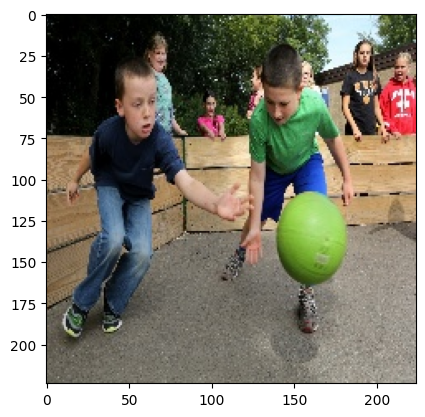

In [76]:
generate_external_caption(jpg_images[6])

--------------------Predicted--------------------
 brown dog is jumping over the grass


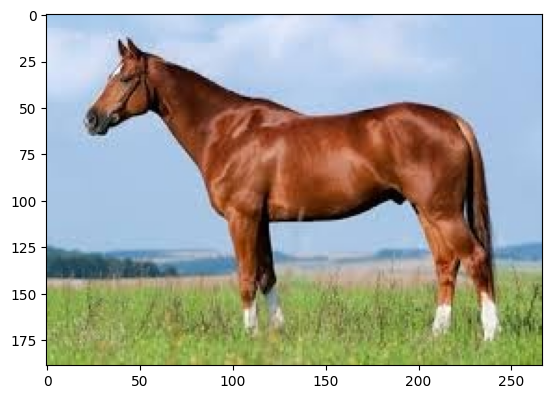

In [85]:
generate_external_caption(jpg_images[1])